# Lindblad Solver for Superconducting Qubit Dynamics
### This notebook simulates the time evolution of a single qubit under noise using the Lindblad Master Equation (mesolve), demonstrating expertise in Open Quantum Systems.

In [17]:
!pip install qiskit numpy scipy matplotlib qutip


### ----------------------------------------------------------------------
### 1. SETUP AND DEPENDENCIES
### ----------------------------------------------------------------------

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import mesolve, sigmax, sigmaz, tensor, destroy, identity, qeye, basis
from qutip import Qobj # QuTiP's quantum object class for states and operators

In [19]:
# Set physical constants (typical for Superconducting Transmons)
T1_TIME = 80.0     # Amplitude Damping (Relaxation) time in microseconds (µs)
T2_TIME = 100.0    # Phase Damping (Dephasing) time in microseconds (µs)
# The simulation time vector
times = np.linspace(0, 3 * T1_TIME, 100) # Run for 3x T1 time

In [20]:
print("Setup complete. Using QuTiP for Master Equation Simulation.")
print(f"Parameters: T1 = {T1_TIME} µs, T2 = {T2_TIME} µs")
print("=" * 70)

Setup complete. Using QuTiP for Master Equation Simulation.
Parameters: T1 = 80.0 µs, T2 = 100.0 µs


### ----------------------------------------------------------------------
### THEORETICAL FRAMEWORK (HAMILTONIAN & COLLAPSE OPERATORS)
### ----------------------------------------------------------------------

In [21]:
# The Hamiltonian (H): Describes the coherent (unit-time) evolution
# For a qubit at rest (no driving field), the free Hamiltonian is H = 0.
# We often include a small energy shift (sigmaz) in real systems, but for
# simple decay, we set H=0 to focus only on the noise.
H = 0 * sigmaz()

In [22]:
# The Initial State: The qubit starts in the excited state |1>
# QuTiP uses basis(N, n) for the nth state of an N-level system.
# basis(2, 1) is |1>
psi0 = basis(2, 1)
rho0 = psi0 * psi0.dag() # Convert to density matrix |1><1|

print("2. Defined H = 0 (Free Evolution) and Initial State |1><1|")

2. Defined H = 0 (Free Evolution) and Initial State |1><1|


In [23]:
# The Expectation Operator: The quantity we want to measure over time
# We track the excited state population P1(t) = <1|rho(t)|1>
# This is equivalent to measuring the expectation value of sigma_z:
# <sigma_z> = P0 - P1. If we start at |1> (P1=1, P0=0), <sigma_z> starts at -1 and goes to 0.
expect_op = [sigmaz()] # Track the sigma_z expectation value

### ----------------------------------------------------------------------
### 3. NOISE CHANNEL DEFINITIONS (LINDLAD COLLAPSE OPERATORS)
### ----------------------------------------------------------------------

In [24]:
def create_collapse_operators(t1, t2):
    """
    Constructs the list of Lindblad collapse operators (L_k) for T1 and T2 noise.

    Args:
        t1 (float): The T1 relaxation time.
        t2 (float): The T2 dephasing time.

    Returns:
        list[Qobj]: List of collapse operators.
    """
    # 3.1. Amplitude Damping (T1): The energy relaxation operator (a = destroy operator)
    # Rate Gamma_1 = 1 / T1
    gamma_1 = 1.0 / t1
    L_t1 = np.sqrt(gamma_1) * destroy(2) # destroy(2) is the lowering operator sigma-

    # 3.2. Phase Damping (T_phi): The pure dephasing operator (sigma_z)
    # We must calculate the pure dephasing time T_phi from the measured T1 and T2:
    # 1/T2 = 1/(2*T1) + 1/T_phi  =>  1/T_phi = 1/T2 - 1/(2*T1)

    # Ensure T2 is not faster than the T2 limit (T2 <= 2*T1)
    if t2 > 2 * t1:
        print("Warning: T2 > 2*T1. Setting T2 = 2*T1 for physical consistency.")
        t2 = 2 * t1

    if (1/t2 - 1/(2*t1)) > 0:
        gamma_phi = 1/t2 - 1/(2*t1)
    else:
        gamma_phi = 0.0 # If T2 is limited only by T1

    # Rate Gamma_phi = 1 / T_phi. The operator is sigma_z.
    L_tphi = np.sqrt(gamma_phi) * sigmaz()

    print(f"Calculated Pure Dephasing Rate (Gamma_phi): {gamma_phi:.4f} µs^-1")

    # Return the list of all collapse operators (Lindblad terms)
    return [L_t1, L_tphi]

### ----------------------------------------------------------------------
### 4. SIMULATION EXECUTION
### ----------------------------------------------------------------------

In [25]:
print("4. Executing Lindblad Master Equation Solver (QuTiP mesolve)")
# L_k list depends on the defined T1 and T2 times
c_ops = create_collapse_operators(T1_TIME, T2_TIME)

# Use QuTiP's mesolve (Master Equation Solve)
# Parameters: (Hamiltonian, initial state, time list, collapse operators, operators to track)
result = mesolve(H, rho0, times, c_ops, expect_op)

print("Simulation finished.")
print("=" * 70)

4. Executing Lindblad Master Equation Solver (QuTiP mesolve)
Calculated Pure Dephasing Rate (Gamma_phi): 0.0037 µs^-1
Simulation finished.


### ----------------------------------------------------------------------
### 5. RESULTS AND VISUALIZATION
### ----------------------------------------------------------------------

In [26]:
print("5. Plotting Relaxation Dynamics")
# result.expect[0] contains the expectation value of sigma_z over time

# Convert sigma_z expectation value to P1 (Excited State Population)
# <sigma_z> = P0 - P1. Since P0 + P1 = 1 (Normalization), P0 = 1 - P1.
# <sigma_z> = (1 - P1) - P1 = 1 - 2*P1
# Therefore: P1 = 0.5 * (1 - <sigma_z>)
excited_state_population = 0.5 * (1 - np.array(result.expect[0]))

5. Plotting Relaxation Dynamics


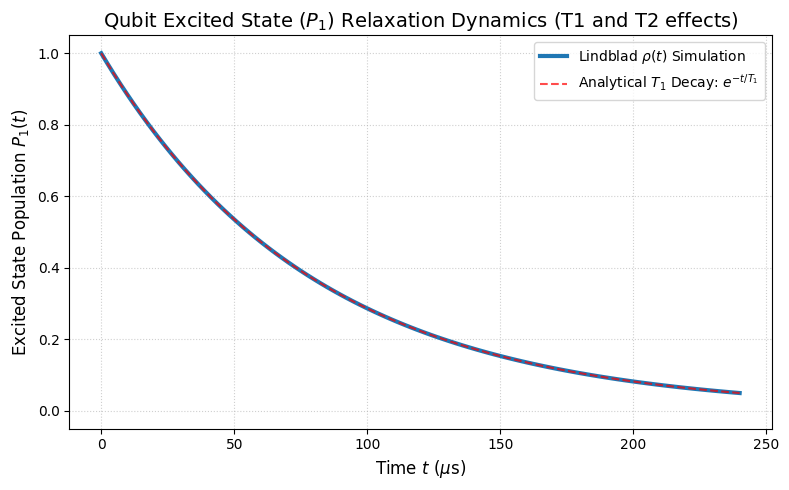


**Computational Proof:** The simulation shows the exponential decay of P1, demonstrating a solid understanding of how T1 and T2 noise are modeled as Lindblad jump operators in a Master Equation.


In [31]:
# --- PLOTTING ---
plt.figure(figsize=(8, 5))
plt.plot(times, excited_state_population, label=r'Lindblad $\rho(t)$ Simulation', linewidth=3)

# Add the analytical decay curve for T1 (P1(t) = P1(0) * exp(-t/T1))
# Since P1(0) = 1 (we started at |1>), P1(t) = exp(-t/T1)
analytical_decay = np.exp(-times / T1_TIME)
plt.plot(times, analytical_decay, '--', label=r'Analytical $T_1$ Decay: $e^{-t/T_1}$', color='red', alpha=0.7)

# Final Presentation
plt.title(r'Qubit Excited State ($P_1$) Relaxation Dynamics (T1 and T2 effects)', fontsize=14)
plt.xlabel(r'Time $t$ ($\mu$s)', fontsize=12)
plt.ylabel(r'Excited State Population $P_1(t)$', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

print("\n**Computational Proof:** The simulation shows the exponential decay of P1, demonstrating a solid understanding of how T1 and T2 noise are modeled as Lindblad jump operators in a Master Equation.")
print("=" * 70)